#EEG CLASSIFICATION FOR ACTIVE TOUCH TASK ACTIVITY
# **Formulation** :

In this project, the main task is to build a classifier that can distinguish between two conditions: with or without tactile stimulation in an active touch task from EEG recordings . A tactile simulation from an electronic pad is used in the experiment . The pad is capable of controlling the presence or absence of tactile simulation. In this study the participants performed an active touch task by touching virtual guitar lines on a tactile display device (Tanvas Touch). Participants moved their index finger from the start point to the end point within one second of the active touch task , at this time the tactile simulation is enabled or disabled randomnly . We call these 2 cases **with/without tactile simulation mode.** EEG signals were recorded during the experiment . From the EEG recording data set, we aim to build a classfier that can distinguish between the two stimulation modes . The data was provided by Wanjoo Park and Mohamed Eid from NYU Abu Dhabi and we used their study for getting our data and building the classifier . A link for the study is listed below (https://link.springer.com/chapter/10.1007/978-3-319-93445-7_3).





# Approach:

There were 24 subjects that were recruited for this experiment in which each of them performed the experiment under both stimulation modes (with/without). Each subject had to undergo 96 trials per mode . EEG data was recorded across 58 channels on the scalp . After the data was recorded, band pass filtering was performed to ensure that the freqeuency range of the EEG signals are between (0.1 -55Hz). Also, each signal was divided into epochs corresponding to with /without tactile stimulation mode. After preprocessing, spectral power densities of each frequency bin(1 -55Hz) were computed.Each of the spectral power density was computed over 70 time indices. The figure below clarifeis the different parameters involved in this experiment.

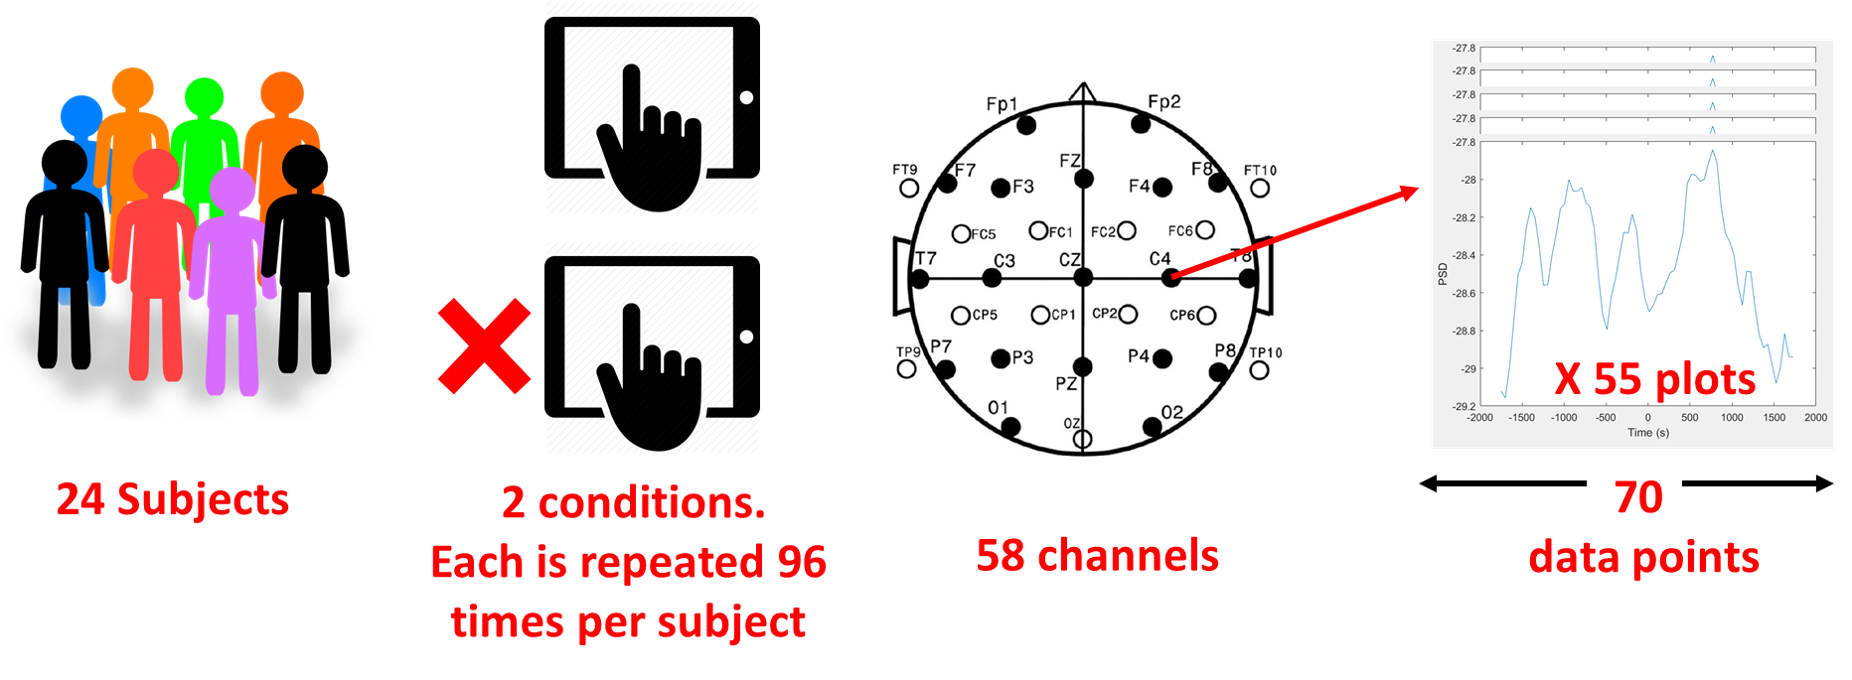

In [0]:
from IPython.display import Image
Image('ml_project_1.png', width=800, height=300)

From the 55 frequency bins, the power spectral densities across 4 frequency bands were computed:


1.   Theta (4 - 7Hz)
2.   Alpha(8-12 Hz)
3.   Beta (13 -30Hz)
4.   Gamma(31-50Hz)

We tried the following approaches for preparing the data prior to feeding it for classfication :


## Approach One (Single Trial Classification: 96 trials per subject per mode ):
For each frequency band, we created 58 data matrices corresponding to 58 EEG channels. In order to generate these matrices, we had to write a data extraction code to extract the data from the given raw data files per subject . Each of the 24 files contained EEG recordings for both the modes (with/without). Each cell within the mode is a 3 dimensional matrix  (55 x 70 x 96) i.e (frequency bins * time indices * trials ) .A sample data file for a particular subject is given below :

https://drive.google.com/open?id=13L2BXRDwVRu-qLVQfNux3FKcM7MdMvh2

We then coded a data extraction logic for the above in MATLAB to generate the data in the required form across the 4 frequency bands .The code is provided in the link :

https://drive.google.com/open?id=1yobHO2ulxreFZab1DZ632qK20UZFZVpq


## Approach Two(Averaged data across 96 trials per subject per mode)

In this approach we averaged the 96 trials per subject per mode and then created 58 matrices (for 58 channels) for the four frequency bands. We generated this from a provided 5 dimensional matrix which contained the EEG recordings for the below information :

1. Stimulation Mode 
2. Channel
3.Frequency Band
4.Subject
5.Time Index

The data file is provided below :
https://drive.google.com/open?id=1BpICL6IlOHVDfO5Ipu-47mbHt3XrgC0T

The data extraction code for the above is provided below:

https://drive.google.com/open?id=1JjurL0WgZ2H8RAC8_KO53L07y5PHa9lZ


It was noticed that the EEG activity starts after time index 35 since the active touch task started after it. Hence, in both the approaches we decided to have a classfication being perfomed for the reduced feature set containing only 35 features as well as the full feature set of 70 features.

## **Approach one:**

We have tried two classification methods:
1.   Logistic Regression
2.   Suport Vector Machine (SVM)

In order to determine the best perfoming channels among the 58 EEG channels across the 4 frequency bands, we trained the data using 2 different types of classifiers mentioned above. Each channel in each frequency band has its own classifer model. The input to each classsifer is a data set of size 4416 * 70 i.e [2(modes)x23(number of subjects)x96(number of trials)] by [70(time indices)] 

### 1. Logistic Regression :

The first classifier we used was Logistic Regression with an L2 penalty associated to it. We initially performed the classification across the beta band and found the channel that gives the maximum accuracy. We got channel 30 with an acccuracy of 55 % , we later coded the logic to find the optimal C value from channel 30 and then utilized this value to get the classfication accuracies for all channels using K -Fold validation .



In [0]:
# code for logistic regression
# Find the best channel using Logistic Regression with Ridge but with a pre define value for C
from sklearn.model_selection import train_test_split
import sklearn.model_selection
import scipy.io
import os
import re
import numpy as np
import warnings
warnings.simplefilter(action = "ignore" ,category =FutureWarning)
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import linear_model,preprocessing
logreg = linear_model.LogisticRegression(C=1e5,penalty='l2')
acc = np.zeros(58)
for i in range(58):
  
  filename="Ch_%d.mat" % (i+1)
  mat = scipy.io.loadmat(filename)
  X = mat['Ch_Matrix']
  y=mat['y']
  y= np.ravel(y)
  # Scale the data
  X_scale = np.interp(X,(X.min(),X.max()),(-1,+1))
  Xtr,Xts,Ytr,Yts = train_test_split(X_scale,y,test_size=0.33,shuffle=True) 
  logreg.fit(Xtr, Ytr)
  yhat = logreg.predict(Xts)
  acc[i] = np.mean(yhat == Yts)
  

In [0]:
print ('Max Accuracy is {0:f}'.format(np.max(acc)))
print ('Channel with max accuracy is : {0:d}'.format(np.argmax(acc) +1 ))


Max Accuracy is 0.552812
Channel with max accuracy is : 30


In [0]:
# Find Optimal C for the channel with maximum Accuracy using cross validation

#Find the best value of C
from sklearn.model_selection import KFold
npen = 20
C_test = np.logspace(-2,2,npen)

# Create the cross-validation object and error rate matrix
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))
num_nonzerocoef = np.zeros((npen,nfold))
# Create the logistic regression object
logreg = linear_model.LogisticRegression(penalty='l2',warm_start=True)

# Loop over the folds in the cross-validation
# Get the channel file with max accuracy
mat = scipy.io.loadmat('Ch_30.mat')
X = mat['Ch_Matrix']
y=mat['y']
y= np.ravel(y)
# Scale the data
X_scale = np.interp(X,(X.min(),X.max()),(-1,+1))
for ifold, Ind in enumerate(kf.split(X_scale)):        
            
    # Get training and test data
  Itr, Its = Ind
  Xtr = X_scale[Itr,:]
  ytr = y[Itr]
  Xts = X_scale[Its,:]
  yts = y[Its]
    
    # Loop over penalty levels
  for ipen, c in enumerate(C_test):
        
    # Set the penalty level      
    logreg.C= c
    
    # Fit a model on the training data
    logreg.fit(Xtr, ytr)
    
    # Predict the labels on the test set.
    yhat = logreg.predict(Xts)
        
    # Measure the accuracy
    err_rate[ipen,ifold] = np.mean(yhat != yts)
    num_nonzerocoef[ipen,ifold]=np.sum(abs(logreg.coef_)>0.001)
  print("Fold %d" % ifold)
    


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


The minimum test error rate =   4.3750e-01, SE=  9.5338e-03
The C value corresponding to minimum error =   1.6238e-02
Optimal C=  1.0000e-02
The test error rate =   4.3977e-01, SE=  9.2817e-03
Accuracy =  0.5602, SE=0.0093


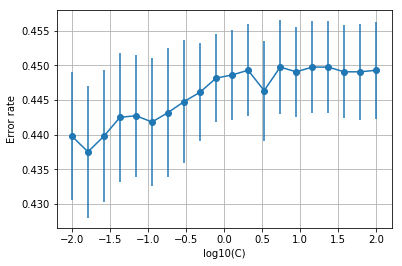

In [0]:
# Plot the error rate
import matplotlib.pyplot as plt
err_mean = np.mean(err_rate, axis=1)
num_nonzerocoef_mean = np.mean(num_nonzerocoef, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

imin = np.argmin(err_mean)

print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = %12.4e" % (C_test[imin]))

err_tgt = err_mean[imin] + err_se[imin]
iopt = np.where(err_mean < err_tgt)[0][0]
C_opt = C_test[iopt]

print("Optimal C=%12.4e" % C_opt)
print("The test error rate = %12.4e, SE=%12.4e" % (err_mean[iopt], err_se[iopt]))

print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(1-err_mean[iopt], err_se[iopt]))


In [0]:
# find the channel with optimal C using cross validation
logreg = linear_model.LogisticRegression(C=C_opt,penalty='l2')
logreg.C= C_opt

# Number of folds
nfold=10

kf=sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
acc=np.zeros((58,nfold))

for i in range(58):
  filename="Ch_%d.mat" % (i+1)
  mat = scipy.io.loadmat(filename)
  X = mat['Ch_Matrix']
  
  y=mat['y']
  y= np.ravel(y)
  
  # Loop over the folds
  for isplit,Ind in enumerate(kf.split(X)):
   
	# Get the training data in the split
    Itr,Its=Ind
	
	#Xtr,Xts,Ytr,Yts = train_test_split(X,y,test_size=0.33,shuffle=True) 
    Xtr = X[Itr]
    Ytr = y[Itr]
    Xts = X[Its]
    Yts = y[Its]
    
    Xtr_scale = np.interp(Xtr,(Xtr.min(),Xtr.max()),(-1,+1))
    Xts_scale = np.interp(Xts,(Xts.min(),Xts.max()),(-1,+1))
    logreg.fit(Xtr, Ytr)
    yhat = logreg.predict(Xts)
    acc[i,isplit] =np.mean(yhat == Yts)




In [0]:
#get the mean of accuracies over all splits
acc_mean=np.mean(acc,axis=1)

#pick the one with max accuracy
print ('Max Accuracy is {0:f}'.format(np.max(acc_mean)))

#Maximum Accuracy is for channel
print ('Channel with max accuracy is : {0:d}'.format(np.argmax(acc_mean) +1))

#Top 5 channels with best accuracy are :
print(np.argsort(acc_mean)[-5:]+1)


Max Accuracy is 0.544843
Channel with max accuracy is : 30
[31 34  1  5 30]


### 2. Support Vector Machines  :

We ran the SVM classfication using a Radial Basis Function (RBF) Kernel on our data set with C as 2.8 and gamma as 0.0073 across 5 folds for the beta band. We found that SVM gives a better accuracy as compared to logistic. Also SVM is more robust comapred to logistic; when we re-run the classfier to compute the accuracies, it was observed that Logistic gives varying accuracies across multiple runs, however SVM gives is more stable and provides repeatable results. 

The code below shows the results of beta band with a normalized scaling of features in the range (-1) to (+1) . However, we ran this code for the other three bands with different scaling methods (Standard Scaler , No Scaling) and got the below observations :

1. Beta : Better accuracy with normalizing features to (-1)  to ( +1).

2. Gamma : Better accuracy for standard scaler.

For each case, we ran the code 3 times to verify our results. In the document below, a comprehensive summay of the results can be found:

https://drive.google.com/open?id=18SnVUKhhRE7rJggBlgnokeTRXghVoYiN

In [0]:
|#Running SVM for beta channel :
#Including 70 features
#Important Libraries and Packages
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
%matplotlib inline
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
import scipy.io
from sklearn import svm
from sklearn.svm import SVC
import sklearn.model_selection
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler





[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([ 5, 31, 35,  2, 34])

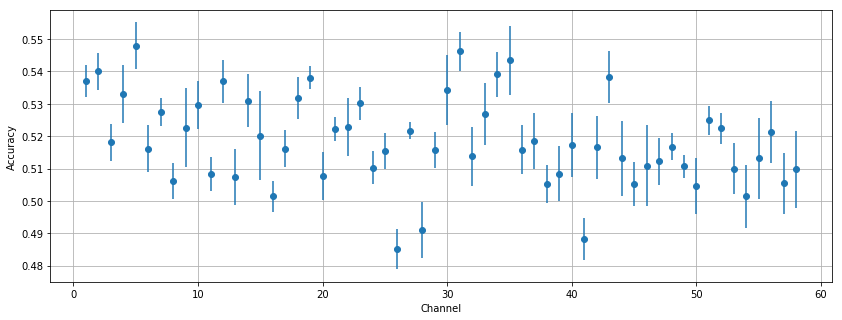

In [0]:
# computing accuracies accross 58 channels
# Including 70 features

accuracy=[]
models=[]
nfold = 5
Rsq = np.zeros((58,nfold))
for i in range(58):

  filename="Ch_%d.mat" % (i+1)
  mat = scipy.io.loadmat(filename)
  X=mat['Ch_Matrix']
  y=mat['y']
  y=np.ravel(y) 
  kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
  for isplit, Ind in enumerate(kf.split(X)):
    
    Itr, Its = Ind
    Xtr=X[Itr,:]
    Xts=X[Its,:]
    ytr=y[Itr]
    yts=y[Its]
    Xtr = np.interp(Xtr, (Xtr.min(), Xtr.max()), (-1, +1))
    Xts = np.interp(Xts, (Xts.min(), Xts.max()), (-1, +1))

    svc = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
    svc.fit(Xtr,ytr)
    yhat=svc.predict(Xts)
    
    acc = np.mean(yhat==yts)
    Rsq[i,isplit]=acc
     
Rsq_mean=np.mean(Rsq,axis=1)
Rsq_std=np.std(Rsq,axis=1)/np.sqrt(nfold-1)
fig, ax = plt.subplots(figsize=(14, 5))
plt.errorbar(np.arange(58)+1,Rsq_mean, yerr=Rsq_std, fmt='o')
plt.xlabel('Channel')
plt.ylabel('Accuracy')
plt.grid()
idx=np.flip(np.argsort(Rsq_mean)[-5:])
maxx=Rsq_mean[idx]
maxx2=Rsq_std[idx]
print('The maximum accuracies are')
print(maxx)
print('The std deviations are:')
print(maxx2)
print('The Channels are')
idx+1

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([ 5, 34,  2, 31,  1])

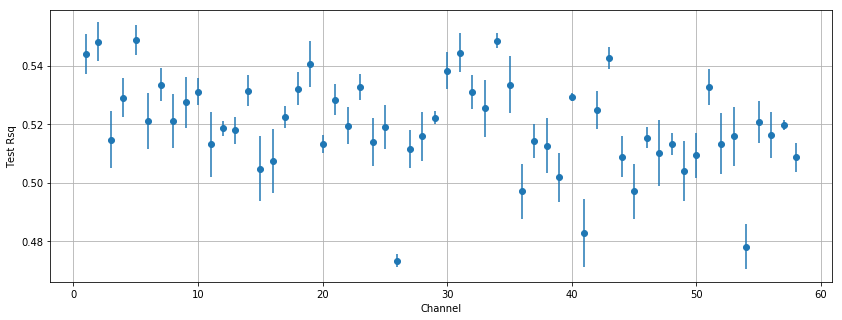

In [0]:
# computing accuracies accross 58 channels
# Including 35 features

accuracy=[]
models=[]
nfold = 5
Rsq = np.zeros((58,nfold))
for i in range(58):

  filename="Ch_%d.mat" % (i+1)
  mat = scipy.io.loadmat(filename)
  X=mat['Ch_Matrix']
  y=mat['y']
  y=np.ravel(y) 
  Xs=X[:,35:]
  kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
  for isplit, Ind in enumerate(kf.split(Xs)):
    
    Itr, Its = Ind
    Xtr=Xs[Itr,:]
    Xts=Xs[Its,:]
    ytr=y[Itr]
    yts=y[Its]
    Xtr = np.interp(Xtr, (Xtr.min(), Xtr.max()), (-1, +1))
    Xts = np.interp(Xts, (Xts.min(), Xts.max()), (-1, +1))

    svc = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
    svc.fit(Xtr,ytr)
    yhat=svc.predict(Xts)
    
    acc = np.mean(yhat==yts)
    Rsq[i,isplit]=acc
     
Rsq_mean=np.mean(Rsq,axis=1)
Rsq_std=np.std(Rsq,axis=1)/np.sqrt(nfold-1)
fig, ax = plt.subplots(figsize=(14, 5))
plt.errorbar(np.arange(58)+1,Rsq_mean, yerr=Rsq_std, fmt='o')
plt.xlabel('Channel')
plt.ylabel('Test Rsq')
plt.grid()
idx=np.flip(np.argsort(Rsq_mean)[-5:])
maxx=Rsq_mean[idx]
maxx2=Rsq_std[idx]
print('The maximum accuracies are')
print(maxx)
print('The std deviations are:')
print(maxx2)
print('The Channels are')
idx+1

## Approach two:
We have tried below classification method which is:

1.Suport Vector Machine (SVM)

In order to determine the best perfoming channels among the 58 EEG channels across the 4 frequency bands mentioned above we trained the data using 2 different types of classifiers mentioned above . The input to each classsifer is a data set of size 48 * 70 i.e [2(modes)24(number of subjects)] X [70(time indices)]


Similar comprehensive analysis was done, just as in Approach one with respect to the features sizr (70 vs 35) and scaling methods. The summary of the results are in the document below:

https://drive.google.com/open?id=1R7vCEamXTyYFdX6YpmSV6jpbQMim5c0T


In [0]:
#Important Libraries and Packages
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
%matplotlib inline
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
import scipy.io
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import sklearn.model_selection
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([30, 31,  5, 57, 34])

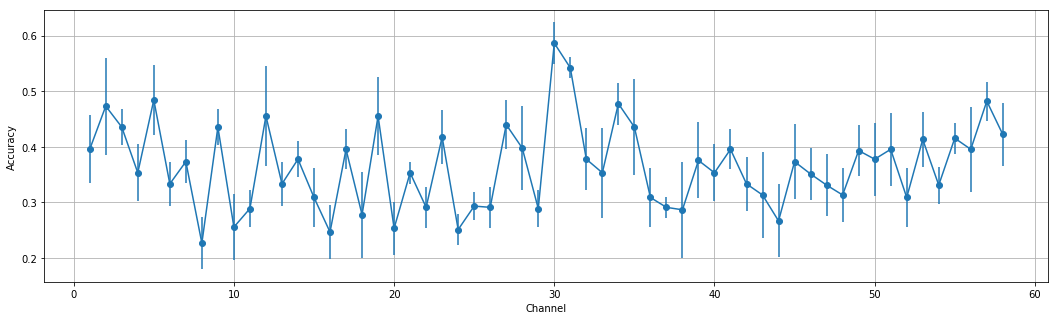

In [0]:
# computing accuracy using all 70 features for beta band with no scaling in SVM
accuracy=[]
models=[]
nfold = 5
Rsq = np.zeros((58,nfold))
for i in range(58):

  filename="Ch_%d.mat" % (i+1)
  mat = scipy.io.loadmat(filename)
  X=mat['PSD1']
  y=mat['y']
  y=np.ravel(y)
  #Xs=X[:,35:]
  kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
  for isplit, Ind in enumerate(kf.split(X)):
 
    Itr, Its = Ind
    Xtr=X[Itr,:]
    Xts=X[Its,:]
    ytr=y[Itr]
    yts=y[Its]
    svc = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
    svc.fit(Xtr,ytr)
    yhat=svc.predict(Xts)
    acc = np.mean(yhat==yts)
    Rsq[i,isplit]=acc
     
Rsq_mean=np.mean(Rsq,axis=1)
Rsq_std=np.std(Rsq,axis=1)/np.sqrt(nfold-1)
fig, ax = plt.subplots(figsize=(18, 5))
plt.errorbar(np.arange(58)+1,Rsq_mean, yerr=Rsq_std, fmt='o-')
plt.xlabel('Channel')
plt.ylabel('Accuracy')
plt.grid()
idx=np.flip(np.argsort(Rsq_mean)[-5:])
maxx=Rsq_mean[idx]
maxx2=Rsq_std[idx]
print('The maximum accuracies are')
print(maxx)
print('The std deviations are:')
print(maxx2)
print('The Channels are')
idx+1

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([30, 31, 33, 34, 52])

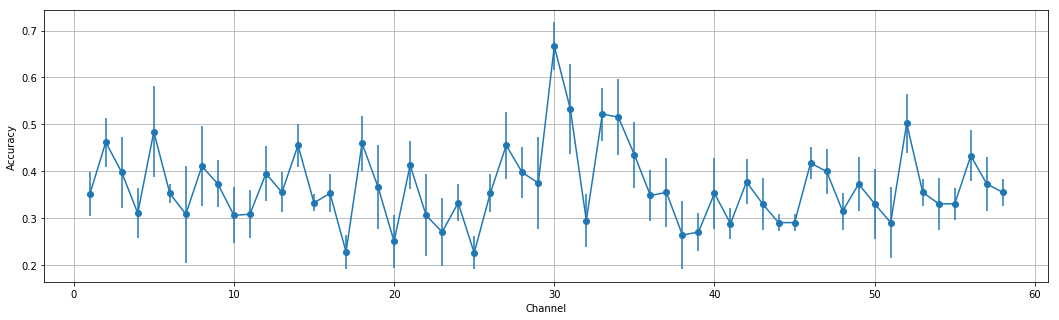

In [0]:
# computing accuracy using only 35 features for beta band with no scaling in SVM
accuracy=[]
models=[]
nfold = 5
Rsq = np.zeros((58,nfold))
for i in range(58):

  filename="Ch_%d.mat" % (i+1)
  mat = scipy.io.loadmat(filename)
  X=mat['PSD1']
  y=mat['y']
  y=np.ravel(y)
  Xs=X[:,35:]
  kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
  for isplit, Ind in enumerate(kf.split(Xs)):
 
    Itr, Its = Ind
    Xtr=Xs[Itr,:]
    Xts=Xs[Its,:]
    ytr=y[Itr]
    yts=y[Its]
    svc = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
    svc.fit(Xtr,ytr)
    yhat=svc.predict(Xts)
    acc = np.mean(yhat==yts)
    Rsq[i,isplit]=acc
     
Rsq_mean=np.mean(Rsq,axis=1)
Rsq_std=np.std(Rsq,axis=1)/np.sqrt(nfold-1)
fig, ax = plt.subplots(figsize=(18, 5))
plt.errorbar(np.arange(58)+1,Rsq_mean, yerr=Rsq_std, fmt='o-')
plt.xlabel('Channel')
plt.ylabel('Accuracy')
plt.grid()
idx=np.flip(np.argsort(Rsq_mean)[-5:])
maxx=Rsq_mean[idx]
maxx2=Rsq_std[idx]
print('The maximum accuracies are')
print(maxx)
print('The std deviations are:')
print(maxx2)
print('The Channels are')
idx+1

The above classification results were computed across all the four frequency bands and we have complied the data in excel and provided below for analysis :



Our Analysis from the two approaches are as folllows :

### Approach 1: 
1. Alpha and theta band are not useful for classfication as their accuracies are low and the best performing channels do not repeat.
2. For beta band the best scaling metric was -1 to +1 normalization .
3. For gamma band the best scaling method was StandardScaler().
4.Best Accuracy is 55% for beta band.
5.Best channels for beta band i.e the ones that exhibit higher accuracy are : 34,30,31
6.Best Accuracy for gamma band is 56%.
7.Best channels for gamma band i.e the ones that exhibit higher accuracy are : 39,23,8

### Approach 2:
1. Alpha and theta band are not useful for classfication as their accuracies are low and the best performing channels do not repeat.
2. For beta band the best scaling metric was no scaling.
3. For gamma band the best scaling method was no scaling.
4.Best Accuracy is 64% for beta band.
5.Best channels for beta band i.e the ones that exhibit higher accuracy are : 34,30,31
6.Best Accuracy for gamma band is 56%.
7.Best channels for gamma band i.e the ones that exhibit higher accuracy are : 39,23,8


From the above analysis it is evident that approach 2 yields a higher accuracy also it justifies the research by stating that beta band provides relevant information for the classifcation , hence going forward we select beta band along with approach 2 for further improving our classification accuracy. Additonally using 35 features only gave a higher accuracy as compared to using 70 features.






## Implementation of the Voting Classfier using Stratified K Fold Validation

Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole. For example in a binary classification problem where each class comprises 50% of the data, it is best to arrange the data such that in every fold, each class comprises around half the instances. Hence we decided to use Stratified K Fold Validation to boost the accuracy .

Additonally we have selected the three top performing channels in the beta band and the two top performing channels from the gamma band and formed a classfier that is based on the collective prediction of these 5 classfiers . We divided this process into 3 steps.

a.**Collective** prediction using the top **3** performing channels of **beta** band only.
b. **Colective** prediction using the top **2** performing channels of **gamma** band only.
c. Collective prediction of 1 & 2 combined.

The following average accuracies were reported across 5 folds for the above mentioned methods :

a.69.5%

b.62.5%

c.68%


Thus method 1 gives the best accuracy , the combined voting i.e method 3 yeilded a slightly lower accuracy due to the presence of gamma band. This again proves that beta band is the best band for classification in this experiment.



In [0]:
#Important Libraries and Packages
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
%matplotlib inline
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
import scipy.io
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import sklearn.model_selection
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import StratifiedKFold




[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Average Accuracy is :0.695000
The maximum accuracies are
[0.5   0.7   0.7   0.7   0.875]


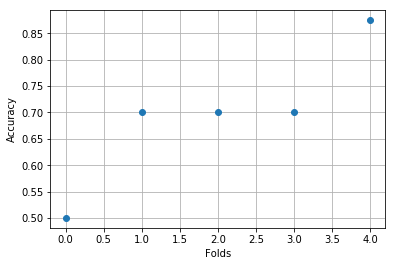

In [0]:
# model code to get output via voting from top 3 good performing channels for beta channel(Channel 30 ,31 & 34)
accuracy=[]
models=[]
nfold = 5
Rsq = np.zeros(nfold)
channel_list = np.array([30,31,34])
#load the files
filename="Ch_30.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
y=mat['y']
y=np.ravel(y)
Xs_ch_1=X[:,35:] 
#channel 31
filename="Ch_31.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
Xs_ch_2=X[:,35:]
#channel 34
filename="Ch_34.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
Xs_ch_3=X[:,35:]

skf = StratifiedKFold(n_splits=nfold,shuffle=True,random_state =23)
i=0
for is_split, Indices in enumerate(skf.split(Xs_ch_1,y)):
    
  Itr, Its = Indices
  Xtr_channel_1=Xs_ch_1[Itr,:]
  Xts_channel_1=Xs_ch_1[Its,:]
  ytr_channel_1=y[Itr]
  yts_channel_1=y[Its]
  # channel 31 
  
  Xtr_channel_2=Xs_ch_2[Itr,:]
  Xts_channel_2=Xs_ch_2[Its,:]
  ytr_channel_2=y[Itr]
  yts_channel_2=y[Its]
  
  #channel 34
  Xtr_channel_3=Xs_ch_3[Itr,:]
  Xts_channel_3=Xs_ch_3[Its,:]
  ytr_channel_3=y[Itr]
  yts_channel_3=y[Its]
  
  
  
  svc_ch_1 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_1.fit(Xtr_channel_1,ytr_channel_1)
  yhat_ch_1=svc_ch_1.predict(Xts_channel_1)
  
  svc_ch_2 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_2.fit(Xtr_channel_2,ytr_channel_2)
  yhat_ch_2=svc_ch_2.predict(Xts_channel_2)
  
  svc_ch_3 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_3.fit(Xtr_channel_3,ytr_channel_3)
  yhat_ch_3=svc_ch_3.predict(Xts_channel_3)
  
  yhat_fold = (yhat_ch_1 + yhat_ch_2 + yhat_ch_3 )/3
  yhat_round = np.rint(yhat_fold)
  # taking yts 30 since the output results are same for all 3 channels check the indices.
  acc = np.mean(yhat_round==yts_channel_1)
  Rsq[i]=acc
  i = i + 1

Rsq_mean=np.mean(Rsq)
print("Average Accuracy is :{0:f}".format(Rsq_mean))
print('The maximum accuracies are')
print(np.sort(Rsq))
Rsq_std=np.std(Rsq)/np.sqrt(nfold-1)
plt.plot(np.arange(5),Rsq,'o')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.grid()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.625
The maximum accuracies are
[0.5   0.6   0.6   0.625 0.8  ]


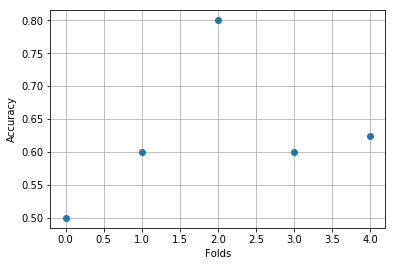

In [0]:
# model code to get output via voting from top 3 good performing channels for gamma channel(Channel 39,23,8)
accuracy=[]
models=[]
nfold = 5
Rsq = np.zeros(nfold)


filename="Ch_39.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
y=mat['y']
y=np.ravel(y)
Xs_ch_1=X[:,35:] 
#channel 31
filename="Ch_23.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
Xs_ch_2=X[:,35:]
#channel 34
filename="Ch_8.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
Xs_ch_3=X[:,35:]
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
skf = StratifiedKFold(n_splits=nfold,shuffle=True,random_state =39)
i=0
for is_split, Indices in enumerate(skf.split(Xs_ch_1,y)):
    
  Itr, Its = Indices
  Xtr_channel_1=Xs_ch_1[Itr,:]
  Xts_channel_1=Xs_ch_1[Its,:]
  ytr_channel_1=y[Itr]
  yts_channel_1=y[Its]
 
  Xtr_channel_2=Xs_ch_2[Itr,:]
  Xts_channel_2=Xs_ch_2[Its,:]
  ytr_channel_2=y[Itr]
  yts_channel_2=y[Its]
  
  Xtr_channel_3=Xs_ch_3[Itr,:]
  Xts_channel_3=Xs_ch_3[Its,:]
  ytr_channel_3=y[Itr]
  yts_channel_3=y[Its]
  
  #load the 3 models for 3 different channels
  svc_ch_1 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_1.fit(Xtr_channel_1,ytr_channel_1)
  yhat_ch_1=svc_ch_1.predict(Xts_channel_1)
  
  svc_ch_2 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_2.fit(Xtr_channel_2,ytr_channel_2)
  yhat_ch_2=svc_ch_2.predict(Xts_channel_2)
  
  svc_ch_3 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_3.fit(Xtr_channel_3,ytr_channel_3)
  yhat_ch_3=svc_ch_3.predict(Xts_channel_3)
  
  yhat_fold = (yhat_ch_1 + yhat_ch_2 + yhat_ch_3 )/3
  yhat_round = np.rint(yhat_fold)
  # taking yts for the first channel since the output results are same for all 3 channels check the indices.
  acc = np.mean(yhat_round==yts_channel_1)
  Rsq[i]=acc
  i = i + 1

Rsq_mean=np.mean(Rsq)

print(Rsq_mean)
print('The maximum accuracies are')
print(np.sort(Rsq))

plt.plot(np.arange(5),Rsq,'o')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.grid()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Average Accuracy of the classfier is:
0.68
The maximum accuracies are
[0.5 0.6 0.7 0.8 0.8]


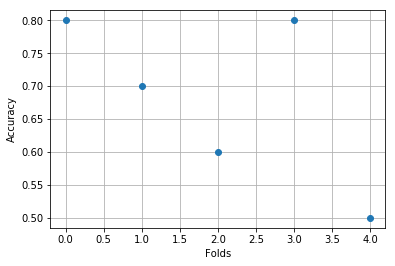

In [0]:
# model code to get output via voting from top 5 good performing channels combining beta and gamma bands.
accuracy=[]
models=[]
nfold = 5
Rsq = np.zeros(nfold)

# channel 34 of beta band
filename="Ch_34.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
y=mat['y']
y=np.ravel(y)
Xs_ch_1=X[:,35:] 
#channel 30 of beta band
filename="Ch_30.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
Xs_ch_2=X[:,35:]
#channel 31 of  beta
filename="Ch_31.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
Xs_ch_3=X[:,35:]

#channel 8 of gamma band
filename="Ch_8.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
Xs_ch_4=X[:,35:]

#channel 23 of gamma band

filename="Ch_23.mat"
mat = scipy.io.loadmat(filename)
X=mat['PSD1']
Xs_ch_5=X[:,35:]

skf = StratifiedKFold(n_splits=nfold,shuffle=True,random_state =41)
i=0
for is_split, Indices in enumerate(skf.split(Xs_ch_1,y)):
    
  Itr, Its = Indices
  Xtr_channel_1=Xs_ch_1[Itr,:]
  Xts_channel_1=Xs_ch_1[Its,:]
  ytr_channel_1=y[Itr]
  yts_channel_1=y[Its]

  
  Xtr_channel_2=Xs_ch_2[Itr,:]
  Xts_channel_2=Xs_ch_2[Its,:]
  ytr_channel_2=y[Itr]
  yts_channel_2=y[Its]
  

  Xtr_channel_3=Xs_ch_3[Itr,:]
  Xts_channel_3=Xs_ch_3[Its,:]
  ytr_channel_3=y[Itr]
  yts_channel_3=y[Its]
  
  Xtr_channel_4=Xs_ch_4[Itr,:]
  Xts_channel_4=Xs_ch_4[Its,:]
  ytr_channel_4=y[Itr]
  yts_channel_4=y[Its]
  
  Xtr_channel_5=Xs_ch_5[Itr,:]
  Xts_channel_5=Xs_ch_5[Its,:]
  ytr_channel_5=y[Itr]
  yts_channel_5=y[Its]
  
  
  
  svc_ch_1 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_1.fit(Xtr_channel_1,ytr_channel_1)
  yhat_ch_1=svc_ch_1.predict(Xts_channel_1)
  
  svc_ch_2 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_2.fit(Xtr_channel_2,ytr_channel_2)
  yhat_ch_2=svc_ch_2.predict(Xts_channel_2)
  
  svc_ch_3 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_3.fit(Xtr_channel_3,ytr_channel_3)
  yhat_ch_3=svc_ch_3.predict(Xts_channel_3)
  
  svc_ch_4 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_4.fit(Xtr_channel_4,ytr_channel_4)
  yhat_ch_4=svc_ch_4.predict(Xts_channel_4)
  
  svc_ch_5 = svm.SVC(probability=False, kernel='rbf', C=2.8, gamma=0.0073, verbose=10)
  svc_ch_5.fit(Xtr_channel_5,ytr_channel_5)
  yhat_ch_5=svc_ch_5.predict(Xts_channel_5)
  
  #implement voting
  
  yhat_fold = (yhat_ch_1 + yhat_ch_2 + yhat_ch_3 + yhat_ch_4 + yhat_ch_5 )/5
  yhat_round = np.rint(yhat_fold)
 
  acc = np.mean(yhat_round==yts_channel_1)
  Rsq[i]=acc
  i = i + 1

Rsq_mean=np.mean(Rsq)
print('Average Accuracy of the classfier is:')
print(Rsq_mean)
print('The maximum accuracies are')
print(np.sort(Rsq))


# plot the figure
plt.plot(np.arange(5),Rsq,'o')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.grid()